In [1]:
# Disclaimer:
# This implementation of VariationalAutoencoder is my interpretation and exercise.
# This implementation is not a book-accurate version.

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import ipywidgets

from fastprogress.fastprogress import master_bar, progress_bar

from data import load_mnist_dataset

In [2]:
batch_size = 64*2

dataset, (train_data_loader, validation_data_loader, test_data_loader) = load_mnist_dataset(batch_size)

In [3]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_space_size):
        super().__init__()
        self.latent_space_size = latent_space_size

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 98),
            nn.ReLU(),
            nn.Linear(98, 24),
            nn.ReLU(),
        )

        self.mu_encoder = nn.Linear(24, latent_space_size)
        self.log_sigma_encoder = nn.Linear(24, latent_space_size)

        self.decoder = nn.Sequential(
            nn.Linear(latent_space_size, 24),
            nn.ReLU(),
            nn.Linear(24, 98),
            nn.ReLU(),
            nn.Linear(98, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(-1, (1, 28, 28)),
        )

    def sample_from_standard_normal(self, size):
        return torch.normal(0, 1, size=size)

    def encode(self, x: torch.Tensor):
        x = self.encoder(x)
        mu: torch.Tensor = self.mu_encoder(x)
        log_sigma: torch.Tensor = self.log_sigma_encoder(x)

        sigma = torch.exp(log_sigma)

        # mu - mean
        # sigma - standard deviation
        assert mu.size() == sigma.size()
        epsilon = self.sample_from_standard_normal(mu.size())

        # Sample x from distribution.
        x_encoded = epsilon * sigma + mu
        return x_encoded, mu, sigma

    def forward(self, x: torch.Tensor):
        x_encoded, mu, sigma = self.encode(x)
        x_decoded = self.decoder(x_encoded)
        return x_decoded, mu, sigma

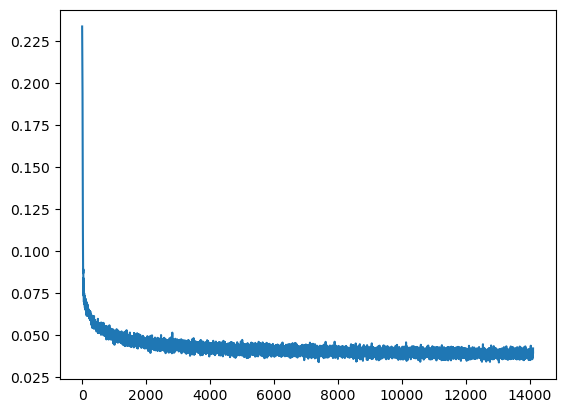

In [4]:
epochs = 50
learning_rate = 1e-3

# betha - VAE (paper)
latent_loss_multiplier = 1
latent_space_size = 2

model = VariationalAutoencoder(latent_space_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def loss_function(target, reconstructed, mu, sigma):
    reconstruction_loss = F.mse_loss(reconstructed, target)

    # This is my interpretation of "the latent space must be useful": we need to be able to sample from it.
    # We are trying to get mu = 0 and sigma = 1
    # mu_loss = F.mse_loss(mu, torch.zeros_like(mu))
    # sigma_loss = F.mse_loss(sigma, torch.ones_like(sigma))
    # latent_loss = mu_loss + sigma_loss

    mu_squared = torch.pow(mu, 2)
    sigma_squared = torch.pow(sigma, 2)

    # KL-Divergence between normal distribution and standard normal distribution.
    # Reference: https://statproofbook.github.io/P/norm-kl.html
    latent_KLD_loss = (1 / 2) * (mu_squared + sigma_squared - torch.log(sigma_squared) - 1)
    latent_loss = latent_KLD_loss

    ELBO_loss = reconstruction_loss + latent_loss_multiplier * latent_loss
    # ELBO_loss = reconstruction_loss
    return ELBO_loss


model.train()
total_loss_history = []
for epoch in (mb := master_bar(range(epochs))):
    for images, _ in (pb := progress_bar(train_data_loader, parent=mb)):
        true_images = images
        images_decoded, mu, sigma = model(true_images)

        loss = loss_function(true_images, images_decoded, mu, sigma)

        total_loss_history.append(loss.item())

        loss_item = loss.item()
        pb.comment = f"Loss: {loss_item}"

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

model.eval()
plt.plot(total_loss_history)
plt.show()

In [5]:
data_iter = iter(test_data_loader)

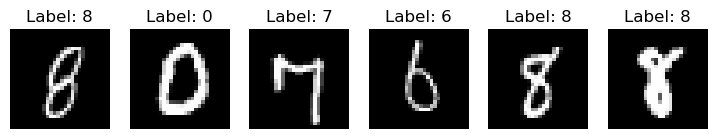

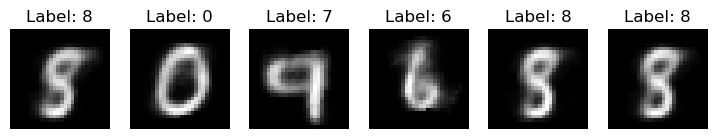

In [6]:
from random import randint

offset = randint(0, 10)
num_col = 6
num_row = 1

for _ in range(offset):
    next(data_iter)
data_x, data_y = next(data_iter)


def plot_images(data_x, title=None):
    fig, axs = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    if title:
        fig.suptitle(title, fontsize=7)

    for i, ax in enumerate(axs.flatten()):
        img = data_x[i].squeeze()
        ax.set_title(f"Label: {data_y[i]}")

        ax.imshow(img, cmap="grey")
        ax.set_axis_off()

    plt.show()


plot_images(data_x)
plot_images(model(data_x)[0].detach().numpy())